# Import Required Libraries and Set Up Configuration
This cell:
- Imports standard libraries for file handling, math operations, and context management.
- Imports PyTorch for deep learning operations.
- Imports Hugging Face Transformers for tokenization and model loading.
- Imports Optimum Quanto for post-training quantization.
- Sets up the model ID, device configuration, and random seed for reproducibility.

In [1]:
import os, shutil, time, math, gc, tempfile, json, contextlib
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

# Optimum (Quanto) for post-training quantization (static, weight-only int8)
from optimum.quanto import quantize, freeze, qint8

MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
SEED     = 42

torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)

# Utilities
This section contains utility functions:
- To measure the size of a directory in megabytes.
- To monitor GPU memory usage during execution.
- To define a data structure for storing generation metrics.

In [2]:
def dir_size_mb(path: str) -> float:
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            total += os.path.getsize(os.path.join(root, f))
    return total / (1024**2)

In [3]:
@contextlib.contextmanager
def torch_cuda_monitor():
    """Context manager to measure peak GPU memory in MB."""
    if DEVICE == "cuda":
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()
        start_alloc = torch.cuda.memory_allocated()
        try:
            yield
        finally:
            torch.cuda.synchronize()
            peak = torch.cuda.max_memory_allocated()
            torch.cuda.empty_cache()
            # return values indirectly by storing on the function object
            torch_cuda_monitor.peak_mb = peak / (1024**2)
            torch_cuda_monitor.start_mb = start_alloc / (1024**2)
    else:
        try:
            yield
        finally:
            torch_cuda_monitor.peak_mb = 0.0
            torch_cuda_monitor.start_mb = 0.0

In [4]:
@dataclass
class GenMetrics:
    latency_s: float
    tokens_per_sec: float
    peak_gpu_mem_mb: float

# Measure Text Generation Performance
This function:
- Measures the latency, throughput, and peak GPU memory usage during text generation.
- Performs a warmup run to stabilize performance.
- Uses multiple runs to calculate average metrics for better accuracy.

In [5]:
def measure_generate(model, tokenizer, prompt: str, max_new_tokens=64, runs=3) -> GenMetrics:
    """Measure latency, throughput, and peak GPU memory for text generation."""
    model.eval()
    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    input_len = inputs["input_ids"].shape[1]

    # Warmup
    with torch.inference_mode():
        _ = model.generate(**inputs, max_new_tokens=8, do_sample=False, use_cache=True)

    latencies, tps = [], []
    with torch_cuda_monitor():
        for _ in range(runs):
            if DEVICE == "cuda":
                torch.cuda.synchronize()
            t0 = time.perf_counter()
            with torch.inference_mode():
                out = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False, use_cache=True)
            if DEVICE == "cuda":
                torch.cuda.synchronize()
            t1 = time.perf_counter()

            gen_len = out.shape[1] - input_len
            lat = t1 - t0
            latencies.append(lat)
            tps.append(gen_len / lat if lat > 0 else float("nan"))

    return GenMetrics(
        latency_s=sum(latencies)/len(latencies),
        tokens_per_sec=sum(tps)/len(tps),
        peak_gpu_mem_mb=getattr(torch_cuda_monitor, "peak_mb", 0.0),
    )

# Compute Perplexity
This function:
- Computes the perplexity of the model using a small built-in evaluation text.
- Evaluates how well the model predicts text by calculating the negative log-likelihood.
- Compares FP32 and INT8 models to observe the impact of quantization on perplexity.

In [6]:
@torch.no_grad()
def compute_perplexity(model, tokenizer, seq_len=128) -> float:
    """
    Self-contained perplexity estimate using a small built-in eval text.
    Keeps evaluation light but still allows FP32 vs INT8 comparison.
    """
    eval_text = (
        "Quantization reduces the precision of neural network weights and activations. "
        "This process shrinks model size, lowers memory use, and can speed up inference. "
        "The tradeoff is a small drop in accuracy. "
        "Perplexity measures how well a language model predicts text: "
        "a lower perplexity means the model is more confident in its predictions. "
        "Large language models like LLaMA or TinyLlama are evaluated on benchmarks such as WikiText, "
        "where perplexity is calculated over thousands of tokens. "
        "In practice, we only need a small text sample to compare relative changes. "
        "By quantizing a model to 8-bit, we can observe whether perplexity increases significantly. "
        "If the rise is modest while speed and memory improve, quantization is usually a good trade-off. "
        "This evaluation text is deliberately extended to ensure enough tokens for testing."
    )

    enc = tokenizer(eval_text, return_tensors="pt")
    input_ids = enc["input_ids"][0]

    usable = (len(input_ids) // seq_len) * seq_len
    input_ids = input_ids[:usable + 1]
    if len(input_ids) <= seq_len:
        raise ValueError("Not enough tokens for perplexity calculation. Try reducing seq_len.")

    nll_sum, tok_count = 0.0, 0
    model.eval()

    for start in range(0, len(input_ids) - 1 - seq_len, seq_len):
        chunk = input_ids[start:start+seq_len+1]
        inp = chunk[:-1].unsqueeze(0).to(DEVICE)
        labels = chunk[1:].unsqueeze(0).to(DEVICE)

        out = model(input_ids=inp, labels=labels)
        nll_sum += float(out.loss) * labels.numel()
        tok_count += labels.numel()

    return math.exp(nll_sum / max(1, tok_count))

# Save Model and Measure Size
This function:
- Saves the model and tokenizer to a specified directory.
- Measures the size of the saved directory in megabytes.
- Ensures the directory is cleaned before saving to avoid conflicts.

In [7]:
def save_and_size(model, tokenizer, out_dir: str) -> float:
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)
    os.makedirs(out_dir, exist_ok=True)
    tokenizer.save_pretrained(out_dir)
    model.save_pretrained(out_dir, safe_serialization=True)
    return dir_size_mb(out_dir)

# Print Metrics Row
This function:
- Prints a formatted row of metrics for a model.
- Includes metrics such as size, latency, throughput, peak GPU memory, and perplexity.
- Provides a clear and concise summary of model performance.

In [8]:
def print_row(title, size_mb, lat_s, tps, gpu_mb, ppl):
    print(
        f"{title:18s} | Size: {size_mb:8.1f} MB | Latency: {lat_s:7.3f} s | "
        f"Throughput: {tps:7.2f} tok/s | Peak VRAM: {gpu_mb:7.1f} MB | PPL: {ppl:7.2f}"
    )

# Load Tokenizer
This cell:
- Loads the tokenizer for the specified model.
- Ensures that padding tokens are set to make generation and perplexity calculations robust.

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
# Some chat models have no pad token; make generation/perplexity robust:
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# Baseline FP32 Model Evaluation
This cell:
- Loads the baseline FP32 model.
- Measures the model's size, latency, throughput, and perplexity.
- Prints the evaluation metrics for the baseline model.

In [10]:
print("\n== Baseline FP32 ==")
baseline_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float32,
    low_cpu_mem_usage=True,
)
baseline_model.to(DEVICE)

baseline_size_mb = save_and_size(baseline_model, tokenizer, out_dir="tinyllama_fp32")
baseline_gen = measure_generate(
    baseline_model,
    tokenizer,
    prompt="Explain quantization in one paragraph for ML engineers.",
    max_new_tokens=128,
    runs=3,
)
baseline_ppl = compute_perplexity(baseline_model, tokenizer, seq_len=128)

print_row("FP32 (baseline)", baseline_size_mb, baseline_gen.latency_s, baseline_gen.tokens_per_sec,
          baseline_gen.peak_gpu_mem_mb, baseline_ppl)


== Baseline FP32 ==
FP32 (baseline)    | Size:   4198.6 MB | Latency:   2.702 s | Throughput:   47.39 tok/s | Peak VRAM:  4218.8 MB | PPL:    1.00


# Quantized INT8 Model Evaluation
This cell:
- Performs post-training quantization (PTQ) on the model using Optimum Quanto.
- Measures the quantized model's size, latency, throughput, and perplexity.
- Prints the evaluation metrics for the quantized model.

In [11]:
print("\n== PTQ INT8 (Optimum-Quanto, weight-only) ==")
q_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float32,
    low_cpu_mem_usage=True,
)

# Static PTQ (weight-only): no calibration set required.
# This converts Linear weights to int8-packed format and wires quant/dequant where needed.
quantize(q_model, weights=qint8)
freeze(q_model)               # finalize quantization graphs / params
q_model.to(DEVICE)

q_size_mb = save_and_size(q_model, tokenizer, out_dir="tinyllama_int8_quanto")

q_gen = measure_generate(
    q_model,
    tokenizer,
    prompt="Explain quantization in one paragraph for ML engineers.",
    max_new_tokens=128,
    runs=3,
)
q_ppl = compute_perplexity(q_model, tokenizer, seq_len=128)

print_row("INT8 (Quanto)", q_size_mb, q_gen.latency_s, q_gen.tokens_per_sec, q_gen.peak_gpu_mem_mb, q_ppl)


== PTQ INT8 (Optimum-Quanto, weight-only) ==
INT8 (Quanto)      | Size:   1240.8 MB | Latency:   6.624 s | Throughput:   19.33 tok/s | Peak VRAM:  5771.4 MB | PPL:    1.00


# Save Summary as JSON
This cell:
- Saves the evaluation metrics for both the FP32 and INT8 models into a JSON file.
- Provides a structured summary of the results for further analysis.

In [ ]:
# --- 5) Summary JSON (optional) ----------------------------------------------
summary = {
    "device": DEVICE,
    "model": MODEL_ID,
    "seed": SEED,
    "baseline_fp32": {
        "size_mb": baseline_size_mb,
        "latency_s": baseline_gen.latency_s,
        "tokens_per_sec": baseline_gen.tokens_per_sec,
        "peak_gpu_mem_mb": baseline_gen.peak_gpu_mem_mb,
        "perplexity": baseline_ppl,
    },
    "int8_quanto": {
        "size_mb": q_size_mb,
        "latency_s": q_gen.latency_s,
        "tokens_per_sec": q_gen.tokens_per_sec,
        "peak_gpu_mem_mb": q_gen.peak_gpu_mem_mb,
        "perplexity": q_ppl,
    },
}
with open("ptq_tinyllama_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\nSaved summary -> ptq_tinyllama_summary.json")



Saved summary -> ptq_tinyllama_summary.json


# Part 2: CPU Quantization and Evaluation
This section:
- Demonstrates dynamic quantization on CPU using PyTorch.
- Evaluates the model's performance in terms of latency and throughput.
- Compares the FP32 and INT8 dynamic quantized models.

In [13]:
import os, time
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.ao.quantization import quantize_dynamic

# -----------------------------
# Config (CPU-only demo)
# -----------------------------
MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # swap to "sshleifer/tiny-gpt2" if CPU is tight
DEVICE = "cpu"
MAX_NEW_TOKENS = 128
RUNS = 3
PROMPT = "Quantization test: explain why int8 dynamic quantization can be faster on CPU."

torch.set_grad_enabled(False)
torch.set_num_threads(max(1, os.cpu_count() or 1))  # let PyTorch use available cores

def measure_generate(model, tokenizer, prompt=PROMPT, max_new_tokens=MAX_NEW_TOKENS, runs=RUNS):
    model.eval()
    tokenizer.padding_side = "left"
    enc = tokenizer(prompt, return_tensors="pt").to(DEVICE)

    # Warmup
    with torch.inference_mode():
        _ = model.generate(**enc, max_new_tokens=8, use_cache=True)

    latencies, throughputs = [], []
    for _ in range(runs):
        t0 = time.perf_counter()
        with torch.inference_mode():
            out = model.generate(**enc, max_new_tokens=max_new_tokens, use_cache=True)
        t1 = time.perf_counter()
        gen_len = out.shape[1] - enc["input_ids"].shape[1]
        lat = t1 - t0
        latencies.append(lat)
        throughputs.append(gen_len / lat)

    return sum(latencies)/len(latencies), sum(throughputs)/len(throughputs)

# -----------------------------
# Tokenizer (shared)
# -----------------------------
tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
if tok.pad_token_id is None:
    tok.pad_token_id = tok.eos_token_id

# -----------------------------
# Baseline: FP32 on CPU
# -----------------------------
print("== CPU FP32 Baseline ==")
model_fp32 = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=torch.float32).to(DEVICE).eval()
model_fp32.config.use_cache = True

lat_fp32, tps_fp32 = measure_generate(model_fp32, tok)
print(f"FP32 (CPU) | Latency {lat_fp32:.3f}s | Throughput {tps_fp32:.2f} tok/s")

# -----------------------------
# Quantized: INT8 dynamic (CPU)
# -----------------------------
print("\n== CPU INT8 (dynamic) ==")
# Quantize only Linear layers to int8 (native PyTorch). This is weight-only int8 + dynamic activation quant.
model_int8 = quantize_dynamic(
    model_fp32.cpu(),
    {torch.nn.Linear},
    dtype=torch.qint8
).eval()

lat_int8, tps_int8 = measure_generate(model_int8, tok)
print(f"INT8 dyn (CPU) | Latency {lat_int8:.3f}s | Throughput {tps_int8:.2f} tok/s")

# -----------------------------
# Summary
# -----------------------------
speedup = lat_fp32 / lat_int8 if lat_int8 > 0 else float("inf")
print("\n== Summary ==")
print(f"CPU FP32 latency: {lat_fp32:.3f}s | CPU INT8 latency: {lat_int8:.3f}s | Speedup: {speedup:.2f}x")
print(f"CPU FP32 tput:   {tps_fp32:.2f} tok/s | CPU INT8 tput:   {tps_int8:.2f} tok/s")


== CPU FP32 Baseline ==
FP32 (CPU) | Latency 0.787s | Throughput 1.28 tok/s

== CPU INT8 (dynamic) ==
INT8 dyn (CPU) | Latency 0.171s | Throughput 7.39 tok/s

== Summary ==
CPU FP32 latency: 0.787s | CPU INT8 latency: 0.171s | Speedup: 4.59x
CPU FP32 tput:   1.28 tok/s | CPU INT8 tput:   7.39 tok/s


# [EX-1] Calibration Set + Static PTQ (Optimum)
This section:
- Implements static PTQ using a calibration dataset.
- Prepares a set of calibration texts and builds a DataLoader for calibration.
- Uses Optimum-Intel to perform static quantization and save the quantized model.

In [14]:
def build_calibration_texts():
    """
    Return ~15–30 short, varied sentences for calibration.
    Mixed styles: facts, questions, lists, numbers, dates, code-ish, etc.
    Each is short to keep tokenization light.
    """
    CALIB_TEXTS = [
        "Neural networks approximate functions by composing linear and nonlinear transformations.",
        "How many parameters are in a small language model with 100 million weights?",
        "Shopping list: apples, rice, coffee beans, and two bottles of water.",
        "Python snippet: for i in range(3): print(i) # demo",
        "In 2024, researchers explored post-training quantization to reduce memory while preserving accuracy.",
        "Temperature today is 18°C with light winds from the west.",
        "Please summarize the article in one concise paragraph.",
        "Quantization maps FP32 weights to lower-precision formats like INT8.",
        "Q: What is perplexity? A: A measure of how confidently a model predicts tokens.",
        "TODO: refactor the data loader and add unit tests for edge cases.",
        "Benchmark setup: batch size 1, max new tokens 64, three runs, median latency.",
        "The matrix A has eigenvalues [1.2, 0.7, 0.1] indicating contraction.",
        "Version 1.3.7 fixed a regression in the tokenizer’s handling of special tokens.",
        "A short story: The rover paused, scanned the ridge, and rolled forward.",
        "CPU vs GPU: choose based on throughput, latency, and cost targets.",
        "Top-3 tasks: clean data, train baseline, and ship a minimal dashboard.",
        "Security note: never log API keys or tokens to stdout.",
        "Quantization-aware training simulates low precision during training to reduce accuracy loss.",
        "Meeting at 10:30 on Friday to review metrics and decide next steps.",
        "Answer in bullet points: speed, memory, energy, and portability.",
        "The dataset contains 120,000 rows and 17 columns, mostly numeric features.",
        "Question: Why does dynamic quantization help Linear layers on CPU?",
        "The compiler emitted warnings about deprecated CUDA kernels.",
        "A recipe: preheat oven to 180°C, mix ingredients, bake for 25 minutes.",
        "Inference logs include time stamps, token counts, and cache-hit ratios.",
        "Note: padding tokens should not affect loss computation or attention.",
        "Checklist: reproducibility, seeding, device placement, and data order.",
        "The model failed to converge with LR=1e-1; try 3e-4 instead.",
        "On-device AI can reduce latency and preserve privacy.",
        "Final reminder: document your experiments and commit configs."
    ]
    return CALIB_TEXTS


def make_calib_dataloader(tokenizer, texts, batch_size=4, max_length=256):
    """
    Build a torch DataLoader yielding dicts with 'input_ids' and 'attention_mask'.
    - Tokenize with truncation + max_length
    - Pad with a simple collator (pad_token_id = tokenizer.pad_token_id or eos as fallback)
    """
    

    class _CalibDS(Dataset):
        def __init__(self, texts_):
            self.texts = texts_
        def __len__(self): 
            return len(self.texts)
        def __getitem__(self, idx):
            enc = tokenizer(
                self.texts[idx],
                truncation=True,
                max_length=max_length,
                return_tensors="pt",
            )
            # squeeze to 1D tensors
            return {k: v.squeeze(0) for k, v in enc.items()}

    pad_id = tokenizer.pad_token_id
    if pad_id is None:
        # Fallback to EOS if the tokenizer has no dedicated PAD
        pad_id = tokenizer.eos_token_id

    def _collate(batch):
        input_ids_list = [b["input_ids"] for b in batch]
        if "attention_mask" in batch[0]:
            attn_list = [b["attention_mask"] for b in batch]
        else:
            # Fallback: all real tokens treated as 1s
            attn_list = [torch.ones_like(b["input_ids"]) for b in batch]

        input_ids = pad_sequence(input_ids_list, batch_first=True, padding_value=pad_id)
        attention = pad_sequence(attn_list, batch_first=True, padding_value=0)
        return {"input_ids": input_ids, "attention_mask": attention}

    ds = _CalibDS(texts)
    return DataLoader(ds, batch_size=batch_size, shuffle=False, collate_fn=_collate)

def run_static_ptq_optimum(model_fp32, tokenizer, calib_texts, out_dir="tinyllama-int8-static"):
    """
    Static PTQ with Optimum-Intel (INC 3.4.1) using a HuggingFace Dataset.
    Expects a list[str] in `calib_texts`.
    """
    import os, shutil
    from datasets import Dataset as HFDataset
    from optimum.intel.neural_compressor import INCQuantizer
    from neural_compressor.config import PostTrainingQuantConfig

    # Clean target dir
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)
    os.makedirs(out_dir, exist_ok=True)

    # Build HF dataset of tokenized samples
    raw_ds = HFDataset.from_dict({"text": calib_texts})
    def _tok(batch):
        return tokenizer(batch["text"], truncation=True, max_length=256)
    calib_ds = raw_ds.map(_tok, batched=True, remove_columns=["text"])

    # Static PTQ: INT8 is default; do not pass dtype/precision in NC 3.4.1
    qconfig = PostTrainingQuantConfig(
        approach="static",
        # calibration_sampling_size=len(calib_ds),  # optional
    )

    # Initialize quantizer from in-memory model (or a model_id string)
    quantizer = INCQuantizer.from_pretrained(model_fp32, task="text-generation")

    # IMPORTANT: use calibration_dataset + save_directory (no dataloader arg in this version)
    quantizer.quantize(
        qconfig,
        calibration_dataset=calib_ds,
        batch_size=4,
        remove_unused_columns=False,  # we already produced the right columns
        save_directory=out_dir,
    )

    return out_dir




# [EX-2] Prompt-Length Sensitivity Sweep
This section:
- Measures latency and throughput across different prompt lengths for each model.
- Plots the results to visualize the impact of prompt length on performance.

In [15]:
def sweep_prompt_lengths(model_dict, tokenizer, prompt, lengths=(16, 64, 256), runs=3):
    """
    For each model, measure latency & throughput across max_new_tokens.
    Returns: {model_key: [{'L': L, 'lat': ..., 'tps': ...}, ...], ...}
    """
    results = {k: [] for k in model_dict.keys()}
    for name, model in model_dict.items():
        for L in lengths:
            lat, tps = measure_generate(model, tokenizer, prompt=prompt, max_new_tokens=L, runs=runs)
            results[name].append({"L": L, "lat": lat, "tps": tps})
    return results


def plot_sweep(results):
    """
    Plot (L vs latency) and (L vs throughput) for each model.
    Uses matplotlib (no custom styles/colors).
    """
    import matplotlib.pyplot as plt

    # Latency
    plt.figure()
    for name, rows in results.items():
        Ls = [r["L"] for r in rows]
        lats = [r["lat"] for r in rows]
        plt.plot(Ls, lats, marker="o", label=name)
    plt.xlabel("max_new_tokens")
    plt.ylabel("Latency (s)")
    plt.title("Latency vs Generation Length")
    plt.legend()
    plt.show()

    # Throughput
    plt.figure()
    for name, rows in results.items():
        Ls = [r["L"] for r in rows]
        tps = [r["tps"] for r in rows]
        plt.plot(Ls, tps, marker="o", label=name)
    plt.xlabel("max_new_tokens")
    plt.ylabel("Throughput (tok/s)")
    plt.title("Throughput vs Generation Length")
    plt.legend()
    plt.show()

# [EX-3] KV-Cache and Padding-Side Ablation
This section:
- Evaluates the impact of KV-cache and padding-side configurations on model performance.
- Measures latency and throughput under different scenarios.

In [16]:
def ablate_cache_and_padding(model, tokenizer, prompt, max_new_tokens=128, runs=3):
    """
    Measure under:
      A) cache on,  padding left
      B) cache off, padding left
      C) cache on,  padding right
      D) cache off, padding right
    """
    original_cache = getattr(model.config, "use_cache", True)
    original_pad = tokenizer.padding_side

    scenarios = {
        "A_cache_on_left":  (True,  "left"),
        "B_cache_off_left": (False, "left"),
        "C_cache_on_right": (True,  "right"),
        "D_cache_off_right":(False, "right"),
    }
    out = {}
    for key, (use_cache, side) in scenarios.items():
        model.config.use_cache = use_cache
        tokenizer.padding_side = side
        lat, tps = measure_generate(model, tokenizer, prompt=prompt, max_new_tokens=max_new_tokens, runs=runs)
        out[key] = {"lat": lat, "tps": tps}

    # restore
    model.config.use_cache = original_cache
    tokenizer.padding_side = original_pad
    return out



# [EX-4] Batch Size Sensitivity (Micro-Batching)
This section:
- Evaluates the model's performance with different batch sizes.
- Measures latency and per-sample throughput for each batch size.

In [17]:
def measure_batched(model, tokenizer, prompt, batch_sizes=(1, 2, 4), max_new_tokens=128, runs=3):
    """
    For B in batch_sizes, build batch by repeating prompt B times and timing a single generate().
    Returns {B: {'lat': ..., 'tps_per_sample': ...}, ...}
    """
    results = {}
    for B in batch_sizes:
        enc = tokenizer([prompt] * B, return_tensors="pt", padding=True).to(DEVICE)

        # warmup
        with torch.inference_mode():
            _ = model.generate(**enc, max_new_tokens=8, use_cache=True)

        lats = []
        tputs = []
        for _ in range(runs):
            t0 = time.perf_counter()
            with torch.inference_mode():
                out = model.generate(**enc, max_new_tokens=max_new_tokens, use_cache=True)
            t1 = time.perf_counter()

            # gen length per sample (all same length due to same prompt)
            gen_len = out.shape[1] - enc["input_ids"].shape[1]
            lat = t1 - t0
            lats.append(lat)
            # per-sample throughput
            tputs.append((gen_len / lat))

        results[B] = {
            "lat": sum(lats)/len(lats),
            "tps_per_sample": sum(tputs)/len(tputs)
        }
    return results


# [EX-5] Disk Size and Peak Memory Accounting
This section:
- Contains utility functions for measuring the disk size of saved models.
- Includes a context manager for tracking peak CPU and GPU memory usage during execution.

In [18]:
def save_and_measure_size(model, tokenizer, out_dir: str) -> int | None:
    """
    Save model+tokenizer to `out_dir` and return total size in BYTES.
    Robust to dynamic INT8 models that can't use `save_pretrained`.
    """
    import os, shutil, json, torch
    from pathlib import Path

    p = Path(out_dir)
    if p.exists():
        shutil.rmtree(p)
    p.mkdir(parents=True, exist_ok=True)

    # Always try to save tokenizer (helps count comparable metadata)
    if getattr(tokenizer, "pad_token_id", None) is None and getattr(tokenizer, "eos_token_id", None) is not None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    try:
        tokenizer.save_pretrained(p.as_posix())
    except Exception as e:
        print(f"[warn] tokenizer.save_pretrained failed: {e}")

    # 1) Try HF-native save_pretrained (works for FP32/most normal models)
    ok = False
    try:
        model.save_pretrained(p.as_posix(), safe_serialization=True)
        ok = True
    except Exception as e:
        print(f"[warn] save_pretrained failed, falling back: {e}")

    if not ok:
        # 2) Fallback: raw state_dict (may still fail for some quantized modules)
        try:
            (p / "config.json").write_text(
                getattr(model, "config", None).to_json_string() if hasattr(model, "config") else "{}"
            )
        except Exception:
            pass
        try:
            torch.save(model.state_dict(), p / "pytorch_model_state_dict.pt")
            ok = True
        except Exception as e:
            print(f"[warn] torch.save(state_dict) failed, last resort pickle: {e}")
            # 3) Last resort: pickle the whole model object (we only need bytes-on-disk)
            try:
                torch.save(model, p / "model_pickle.pt")
                ok = True
            except Exception as e2:
                print(f"[error] torch.save(model) also failed: {e2}")
                return None

    # Compute total bytes
    total = 0
    for root, _, files in os.walk(p):
        for f in files:
            total += os.path.getsize(os.path.join(root, f))
    return total



class PeakMemory:
    """
    Context manager to record peak CPU (and GPU if available) memory during a block.
    CPU via psutil RSS; GPU via torch.cuda.max_memory_allocated().
    """
    def __enter__(self):
        import psutil
        self._psutil = psutil
        self._proc = psutil.Process(os.getpid())
        self.cpu_peak_bytes = self._proc.memory_info().rss
        self.gpu_peak_bytes = 0
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
        return self

    def __exit__(self, exc_type, exc, tb):
        # CPU: we sample once at the end (simple approach).
        self.cpu_peak_bytes = max(self.cpu_peak_bytes, self._proc.memory_info().rss)
        if torch.cuda.is_available():
            self.gpu_peak_bytes = torch.cuda.max_memory_allocated()

# [EX-6] Quality Proxy: Pseudo-Perplexity
This section:
- Implements pseudo-perplexity as a quality proxy for the models.
- Measures how well the model predicts tokens in a leave-one-out style evaluation.

In [ ]:


@torch.no_grad()
def pseudo_perplexity(model, tokenizer, text, max_len=128):
    """
    Leave-one-out style pseudo-perplexity.
    """
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_len)
    input_ids = enc["input_ids"].to(DEVICE)
    attn = enc["attention_mask"].to(DEVICE)
    n = input_ids.shape[1]
    if n < 2:
        return float("nan")

    loss_sum = 0.0
    steps = 0
    for i in range(1, n):  # predict token i given 0..i-1
        out = model(input_ids=input_ids[:, :i], attention_mask=attn[:, :i])
        logits = out.logits[:, -1, :]
        target = input_ids[:, i]
        loss = torch.nn.functional.cross_entropy(logits, target)
        loss_sum += loss.item()
        steps += 1
    avg_loss = loss_sum / max(1, steps)
    return math.exp(avg_loss)


def compare_ppplx(models, tokenizer, texts):
    """
    Compute pseudo-perplexity for each model over `texts` (list[str]).
    Return: {model_key: [scores...], ...}
    """
    scores = {}
    for name, model in models.items():
        scores[name] = [pseudo_perplexity(model, tokenizer, t) for t in texts]
    return scores

# [EX-7] Results Table and Reflection
This section:
- Builds a results table summarizing the evaluation metrics for all models.
- Includes metrics such as size, latency, throughput, and pseudo-perplexity.

In [ ]:
def build_results_table(metrics_rows):
    """
    Build a pandas DataFrame from list of dicts.
    Expected keys per row:
      precision, size_bytes, lat_64, tps_64, lat_256, tps_256, ppplx_avg
    """
    df = pd.DataFrame(metrics_rows)
    # add human-readable MB
    if "size_bytes" in df.columns:
        df["size_MB"] = df["size_bytes"].apply(lambda b: round(b/1024/1024, 1) if pd.notnull(b) else None)
    return df[[
        c for c in [
            "precision","size_bytes","size_MB",
            "lat_64","tps_64","lat_256","tps_256","ppplx_avg"
        ] if c in df.columns
    ]]

# [EX-8 - Stretch] Edge-Case Prompts Check
This section:
- Tests the models with edge-case prompts to evaluate their robustness.
- Generates outputs for challenging prompts and compares the results.

In [21]:
def probe_edge_prompts(models, tokenizer, prompts, max_new_tokens=64):
    """
    Generate for a small set of edge prompts.
    Returns: {model_key: [decoded_outputs...], ...}
    """
    outputs = {k: [] for k in models.keys()}
    for name, model in models.items():
        for p in prompts:
            enc = tokenizer(p, return_tensors="pt").to(DEVICE)
            with torch.inference_mode():
                out_ids = model.generate(**enc, max_new_tokens=max_new_tokens, use_cache=True)
            outputs[name].append(tokenizer.decode(out_ids[0], skip_special_tokens=True))
    return outputs

# Master Controller for the Quantization Exercise
This cell:
- Orchestrates the execution of all parts of the quantization exercise.
- Runs experiments such as prompt-length sweep, cache/padding ablation, and batch-size sensitivity.
- Collects and summarizes results in a structured format.

In [25]:
def run_quantization_exercise(model_fp32, model_int8, tok, PROMPT, save_and_measure_size, PeakMemory):
    """
    Runs: length sweep, cache/padding ablation, batching, size+memory, pseudo-perplexity, edge prompts.
    Assumes:
      - measure_generate() returns (lat, tps)
      - sweep_prompt_lengths(), ablate_cache_and_padding(), measure_batched(),
        compare_ppplx(), build_results_table(), probe_edge_prompts() are defined.
    """

    # Build the model registry for experiments
    models = {"fp32": model_fp32}
    if model_int8 is not None:
        models["int8-dyn"] = model_int8

    # Helper to pull metrics from sweep results
    def _get_metric(sweep, model_key, L, field):
        rows = sweep.get(model_key, [])
        for r in rows:
            if r.get("L") == L:
                return r.get(field)
        return None

    # -------------------------------
    # 1) Prompt-length sensitivity sweep
    # -------------------------------
    print("\n[1] Prompt-length sweep")
    sweep_results = sweep_prompt_lengths(models, tok, PROMPT, lengths=(16, 64, 256))
    plot_sweep(sweep_results)

    # Choose a reference model for later steps
    ref_key = "int8-dyn" if "int8-dyn" in models else "fp32"
    ref_model = models[ref_key]

    # -------------------------------
    # 2) KV-cache & padding ablation (on the reference model)
    # -------------------------------
    print(f"\n[2] Cache & padding ablation (on: {ref_key})")
    ablation = ablate_cache_and_padding(ref_model, tok, PROMPT)
    print("Ablation results:", ablation)

    # -------------------------------
    # 3) Batch-size sensitivity (on the reference model)
    # -------------------------------
    print(f"\n[3] Batch-size sensitivity (on: {ref_key})")
    batch_res = measure_batched(ref_model, tok, PROMPT)
    print("Batch results:", batch_res)

    # -------------------------------
    # 4) Model size + memory tracking
    # -------------------------------
    print("\n[4] Model size + memory")
    size_fp32 = save_and_measure_size(model_fp32, tok, "fp32-save")
    size_int8_dyn = save_and_measure_size(model_int8, tok, "int8dyn-save") if "int8-dyn" in models else None

    with PeakMemory() as pm:
        _ = measure_generate(ref_model, tok, PROMPT, max_new_tokens=64)
    print("Peak memory (CPU/GPU):", pm.cpu_peak_bytes, pm.gpu_peak_bytes)

    # -------------------------------
    # 5) Quality proxy: pseudo-perplexity
    # -------------------------------
    print("\n[5] Quality proxy (pseudo-perplexity)")
    texts = ["Quantization reduces model size.", "Speed matters for deployment."]
    ppplx_scores = compare_ppplx(models, tok, texts)
    print("PPPLX:", ppplx_scores)

    # -------------------------------
    # 6) Build results table
    # -------------------------------
    print("\n[6] Summary table")
    metrics = []

    metrics.append({
        "precision": "FP32",
        "size_bytes": size_fp32,
        "lat_64":  _get_metric(sweep_results, "fp32", 64,  "lat"),
        "tps_64":  _get_metric(sweep_results, "fp32", 64,  "tps"),
        "lat_256": _get_metric(sweep_results, "fp32", 256, "lat"),
        "tps_256": _get_metric(sweep_results, "fp32", 256, "tps"),
        "ppplx_avg": (sum(ppplx_scores.get("fp32", [])) / max(1, len(ppplx_scores.get("fp32", []))))
    })

    if "int8-dyn" in models:
        metrics.append({
            "precision": "INT8-dyn (CPU)",
            "size_bytes": size_int8_dyn,
            "lat_64":  _get_metric(sweep_results, "int8-dyn", 64,  "lat"),
            "tps_64":  _get_metric(sweep_results, "int8-dyn", 64,  "tps"),
            "lat_256": _get_metric(sweep_results, "int8-dyn", 256, "lat"),
            "tps_256": _get_metric(sweep_results, "int8-dyn", 256, "tps"),
            "ppplx_avg": (sum(ppplx_scores.get("int8-dyn", [])) / max(1, len(ppplx_scores.get("int8-dyn", []))))
        })

    df = build_results_table(metrics)
    print(df)

    # -------------------------------
    # 7) (Stretch) Edge prompts
    # -------------------------------
    print("\n[7] Edge-case prompts")
    edge_prompts = [
        "Supercalifragilisticexpialidocious",
        "12345678901234567890",
        "A very very very very very long name...",
    ]
    outputs = probe_edge_prompts(models, tok, edge_prompts)
    for m, outs in outputs.items():
        print(f"--- {m} ---")
        for o in outs:
            print(o)
            print("=" * 40)

    return {
        "sweep": sweep_results,
        "ablation": ablation,
        "batch": batch_res,
        "sizes": (size_fp32, size_int8_dyn),
        "ppplx": ppplx_scores,
        "table": df,
        "edge_outputs": outputs
    }


# Run the Quantization Exercise
This cell:
- Executes the master controller function to run all parts of the quantization exercise.
- Collects and prints the results for analysis.


[1] Prompt-length sweep


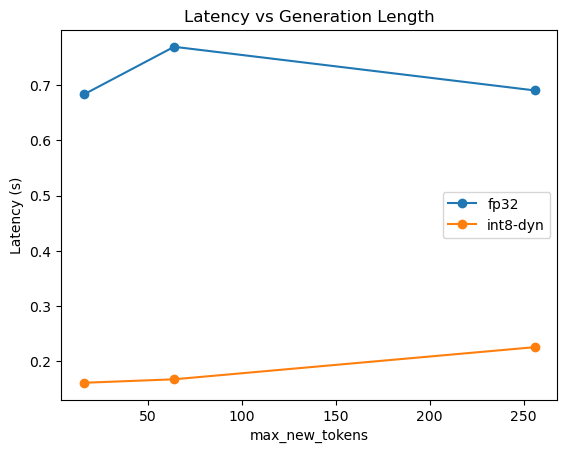

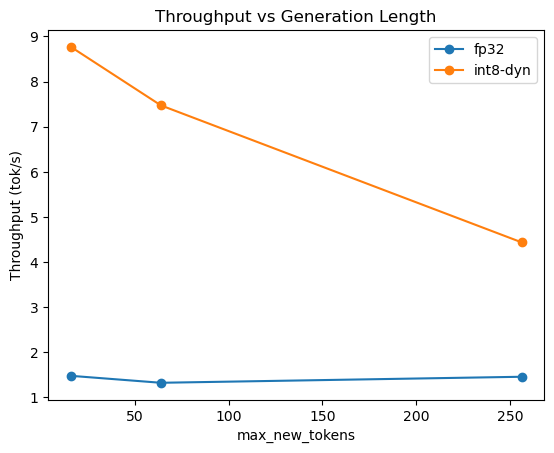


[2] Cache & padding ablation (on: int8-dyn)
Ablation results: {'A_cache_on_left': {'lat': 0.22545417064490417, 'tps': 4.436752856085373}, 'B_cache_off_left': {'lat': 0.1691590944149842, 'tps': 8.514883360395713}, 'C_cache_on_right': {'lat': 0.16918594700594744, 'tps': 7.0528541734662875}, 'D_cache_off_right': {'lat': 0.2036272215967377, 'tps': 5.001046873875578}}

[3] Batch-size sensitivity (on: int8-dyn)
Batch results: {1: {'lat': 0.1129904785969605, 'tps_per_sample': 10.53523427399191}, 2: {'lat': 0.18161187569300333, 'tps_per_sample': 7.295849081359471}, 4: {'lat': 0.21545228261190155, 'tps_per_sample': 5.545868262145601}}

[4] Model size + memory
[warn] save_pretrained failed, falling back: 'torch.dtype' object has no attribute 'data_ptr'
Peak memory (CPU/GPU): 11152576512 5776738304

[5] Quality proxy (pseudo-perplexity)
PPPLX: {'fp32': [467.89175668934826, 6308.311311027291], 'int8-dyn': [494.62983688680976, 6558.688527128666]}

[6] Summary table
        precision  size_bytes  s

In [26]:
results = run_quantization_exercise(model_fp32, model_int8, tok, PROMPT, save_and_measure_size, PeakMemory)


# Additional Notes or Code
This cell is reserved for any additional notes or code that may be required.

In [ ]:
# ...existing code...